In [74]:
import glob
import os
import pathlib

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    # experimental,
)
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

In [75]:
data_dir_train = pathlib.Path("../data/Train")
data_dir_test = pathlib.Path("../data/Test")

In [76]:
image_train = list(data_dir_train.glob("*/*.jpg"))
print(len(image_train))
image_test = list(data_dir_test.glob("*/*.jpg"))
print(len(image_test))

2239
118


In [77]:
batch_size = 32
img_height = 180
img_width = 180

In [78]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [79]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [80]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


2024-07-14 21:05:13.089624: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


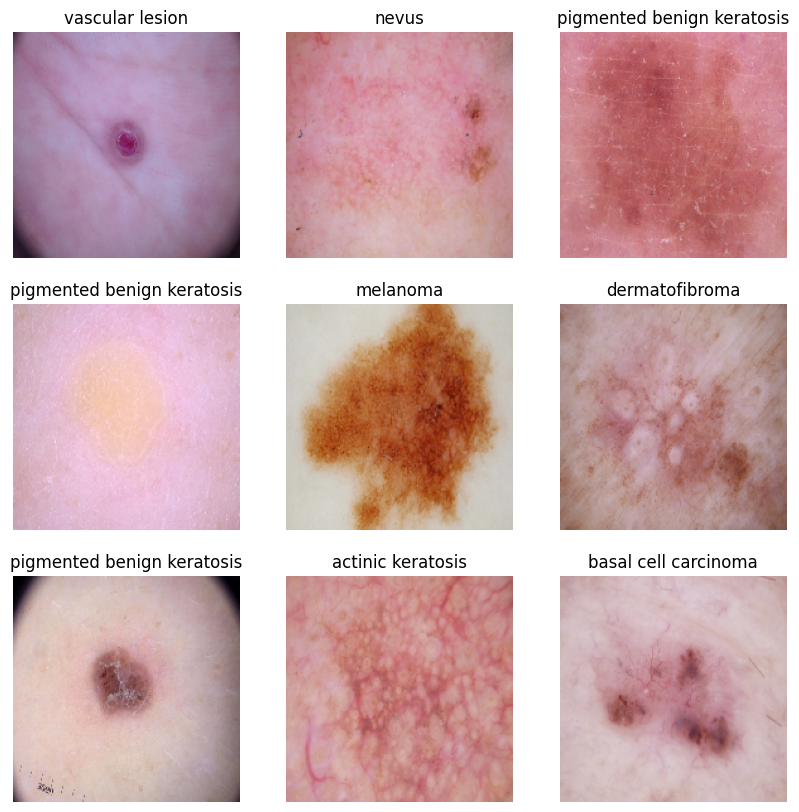

In [81]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [82]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [83]:
num_classes = len(class_names)

model = Sequential(
    [
        Rescaling(
            1.0 / 255, input_shape=(img_height, img_width, 3)
        ),
        Conv2D(16, 3, padding="same", activation="relu"),
        MaxPooling2D(),
        Conv2D(32, 3, padding="same", activation="relu"),
        MaxPooling2D(),
        Conv2D(64, 3, padding="same", activation="relu"),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(num_classes),
    ]
)

In [84]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [85]:
model.summary(expand_nested=True, show_trainable=True)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ rescaling_8 (Rescaling)     │ (None, 180, 180, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_24 (Conv2D)          │ (None, 180, 180, 16)  │        448 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_24            │ (None, 90, 90, 16)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_25 (Conv2D)          │ (None, 90, 90, 32)    │      4,640 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_25            │ (None, 45, 45, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_26 (Conv2D)          │ (None, 45, 45, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_26            │ (None, 22, 22, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_8 (Flatten)         │ (None, 30976)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_16 (Dense)            │ (None, 128)           │  3,965,056 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_17 (Dense)            │ (None, 9)             │      1,161 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.1838 - loss: 2.1594 - val_accuracy: 0.3669 - val_loss: 1.8709
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.3215 - loss: 1.8666 - val_accuracy: 0.3647 - val_loss: 1.7305
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.4455 - loss: 1.5664 - val_accuracy: 0.4698 - val_loss: 1.5059
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.4728 - loss: 1.4413 - val_accuracy: 0.4273 - val_loss: 1.5985
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.5206 - loss: 1.3348 - val_accuracy: 0.5235 - val_loss: 1.4000
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.5789 - loss: 1.1827 - val_accuracy: 0.5391 - val_loss: 1.3748
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.6023 - loss: 1.1214 - val_accuracy: 0.5459 - val_loss: 1.4035
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.6239 - loss: 1.0445 - val_accu

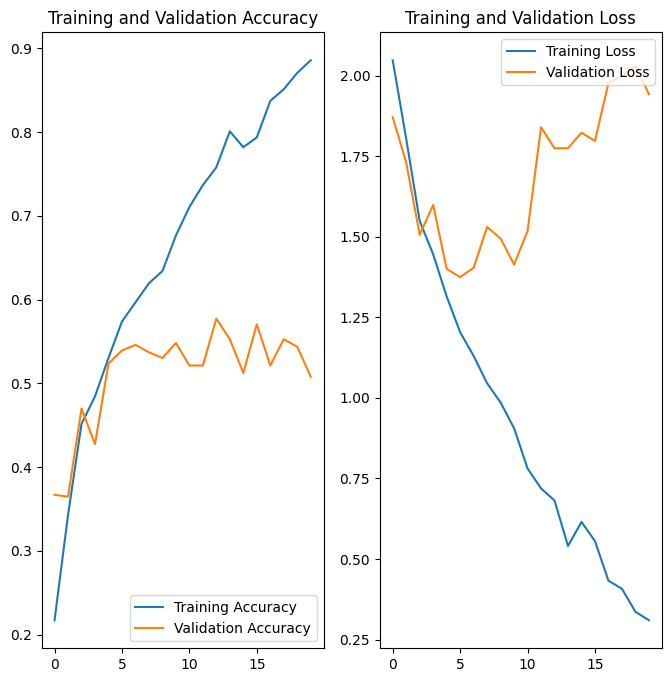

In [87]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [88]:
data_augmentation = Sequential([
    RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
])


In [89]:
model = Sequential([
    data_augmentation,
    Rescaling(1.0 / 255),
    Conv2D(16, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(num_classes)  # Note: no activation function here
])


In [90]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [91]:
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.2223 - loss: 2.1065 - val_accuracy: 0.3937 - val_loss: 1.7253
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.3654 - loss: 1.7201 - val_accuracy: 0.4273 - val_loss: 1.6330
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.4051 - loss: 1.6482 - val_accuracy: 0.4116 - val_loss: 1.5839
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.4582 - loss: 1.5279 - val_accuracy: 0.4966 - val_loss: 1.4550
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.5075 - loss: 1.4222 - val_accuracy: 0.5235 - val_loss: 1.4337
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.4949 - loss: 1.4293 - val_accuracy: 0.5078 - val_loss: 1.5096
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.5185 - loss: 1.3558 - val_accuracy: 0.4855 - val_loss: 1.4580
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.5239 - loss: 1.3722 - val_accu

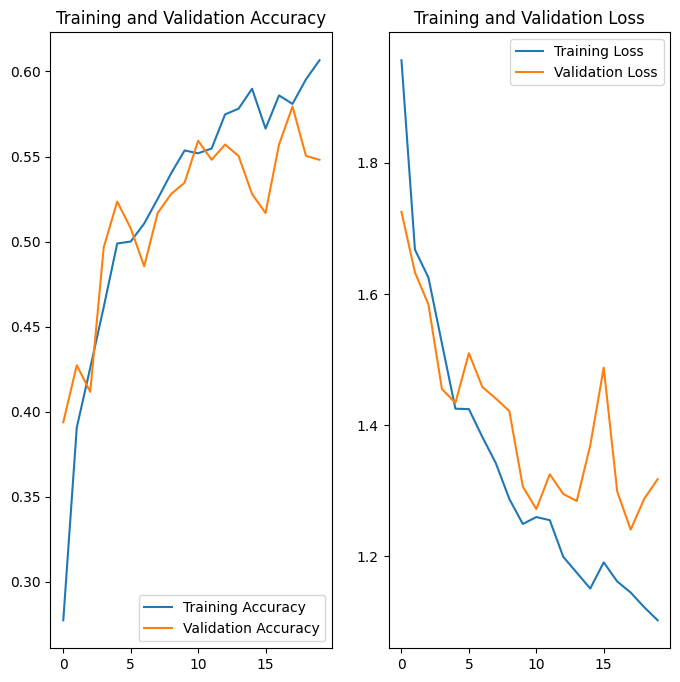

In [92]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [93]:
# model accuracy
accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy[1]*100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5890 - loss: 1.2475
Accuracy: 54.81%


In [95]:
model.save("saved_model.keras")